## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [55]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [7]:
file = 'data-hm.csv'
if os.path.exists(file):
    pass
else:
    data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
    !wget $data -O data-hm.csv 

--2025-10-20 20:05:30--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘data-hm.csv’

data-hm.csv         100%[===================>]  78.98K  --.-KB/s    in 0.006s  

2025-10-20 20:05:30 (12.6 MB/s) - ‘data-hm.csv’ saved [80876/80876]



In [13]:
df = pd.read_csv('data-hm.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [14]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [15]:
categorical_columns, numerical_columns

(['lead_source', 'industry', 'employment_status', 'location'],
 ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score',
  'converted'])

In [17]:
df[categorical_columns] = df[categorical_columns].fillna('NA')

In [20]:
df[numerical_columns] = df[numerical_columns].fillna(0.0)

In [22]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [23]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [24]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [25]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score']

In [30]:
for c in numerical:

    score = roc_auc_score(y_train, df_train[c])
    print('Score = %f %s' % (score, c))

Score = 0.763568 number_of_courses_viewed
Score = 0.551958 annual_income
Score = 0.738270 interaction_count
Score = 0.614499 lead_score


#### The numerical variable that has the highest AUC is `number_of_courses_viewed`

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [38]:
def train(df, y, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred



In [39]:
dv, model = train(df_train, y_train, C=1.0)
y_pred = predict(df_val, dv, model)
    
auc = roc_auc_score(y_val, y_pred)
round(auc,3)

0.817

#### The closest answer to the AUC Score obtained is `0.72`

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [41]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [46]:
thresholds = np.linspace(0,1,101)

scores = []

for t in thresholds:
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))


columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores
    
   # p = tp/(tp+fp)
   # r = tp/(tp+fn)

,thresholds,tp,fp,fn,tn
0,0.00,171,122,0,0
1,0.01,171,122,0,0
2,0.02,171,122,0,0
3,0.03,171,122,0,0
4,0.04,171,122,0,0
...,...,...,...,...,...
96,0.96,3,0,168,122
97,0.97,1,0,170,122
98,0.98,0,0,171,122
99,0.99,0,0,171,122


In [48]:
df_scores['prec'] = df_scores.tp / (df_scores.tp+df_scores.fp)

df_scores['rec'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores

,thresholds,tp,fp,fn,tn,prec,rec
0,0.00,171,122,0,0,0.583618,1.000000
1,0.01,171,122,0,0,0.583618,1.000000
2,0.02,171,122,0,0,0.583618,1.000000
3,0.03,171,122,0,0,0.583618,1.000000
4,0.04,171,122,0,0,0.583618,1.000000
...,...,...,...,...,...,...,...
96,0.96,3,0,168,122,1.000000,0.017544
97,0.97,1,0,170,122,1.000000,0.005848
98,0.98,0,0,171,122,NaN,0.000000
99,0.99,0,0,171,122,NaN,0.000000


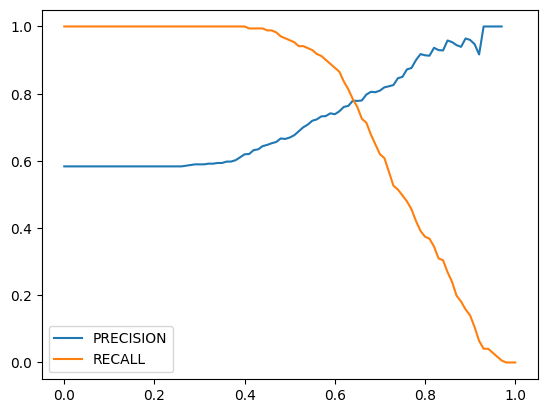

In [49]:
plt.plot(df_scores.thresholds, df_scores['prec'], label='PRECISION')
plt.plot(df_scores.thresholds, df_scores['rec'], label='RECALL')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [52]:
df_scores['F1'] = 2 * ((df_scores.prec*df_scores.rec)/(df_scores.prec+df_scores.rec))

df_scores

,thresholds,tp,fp,fn,tn,prec,rec,F1
0,0.00,171,122,0,0,0.583618,1.000000,0.737069
1,0.01,171,122,0,0,0.583618,1.000000,0.737069
2,0.02,171,122,0,0,0.583618,1.000000,0.737069
3,0.03,171,122,0,0,0.583618,1.000000,0.737069
4,0.04,171,122,0,0,0.583618,1.000000,0.737069
...,...,...,...,...,...,...,...,...
96,0.96,3,0,168,122,1.000000,0.017544,0.034483
97,0.97,1,0,170,122,1.000000,0.005848,0.011628
98,0.98,0,0,171,122,NaN,0.000000,NaN
99,0.99,0,0,171,122,NaN,0.000000,NaN


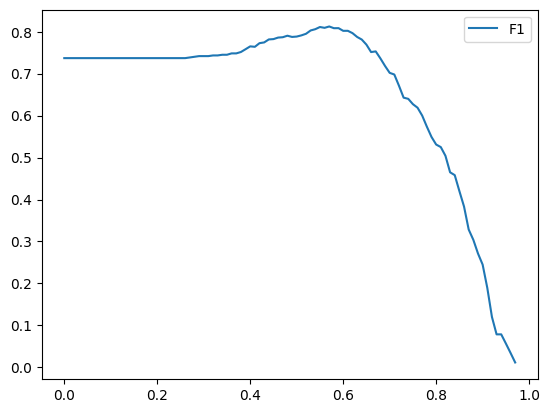

In [53]:
plt.plot(df_scores.thresholds, df_scores['F1'], label='F1')
plt.legend()

#### The maximal F1 value is when the threshold is close to `0.54`

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [62]:
def train(df, y, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred



In [63]:
n_splits = 5

scores = []
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)


for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values
    
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print('%f +- %f' % (np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

0.822109 +- 0.035807


#### The standar deviation of the scores is `0.035807`. The closest answer to int is `0.06`.

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [64]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
   
    scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    
    for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits):
        
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s  %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

C=1e-06  0.560 +- 0.024


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.001  0.867 +- 0.029


  0%|          | 0/5 [00:00<?, ?it/s]

C=1  0.822 +- 0.036


The best mean score was using the `C value of 0.001`.